In [43]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder  

In [44]:
try:
    df = pd.read_json('problems_data.jsonl', lines=True)
except ValueError:
    print("Error: check filetype again")
    exit()

In [45]:
df = df.dropna(subset=['problem_score', 'problem_class'])
le = LabelEncoder()
df['difficulty_label'] = le.fit_transform(df['problem_class'])
class_mapping = {k: int(v) for k, v in zip(le.classes_, le.transform(le.classes_))} #int(v) so int64 doesn't come
print("Mapping:", class_mapping) #yo remember hard is 1
text_columns = ['title', 'description', 'input_description', 'output_description']
for col in text_columns:
    df[col] = df[col].fillna('')

df['combined_text'] = (
    df['title'] + " " + 
    df['description'] + " " + 
    df['input_description'] + " " + 
    df['output_description']
)

def upd(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = " ".join(text.split())
    return text

df['combined_text'] = df['combined_text'].apply(upd)

Mapping: {'easy': 0, 'hard': 1, 'medium': 2}


In [46]:
hard_topics = [
    'convex hull', 'mobius', 'segment tree', 'flow', 'centroid', 
    'geometry', 'gcd', 'subarray', 'mex', 'dynamic programming', 
    'modulo', 'bitwise', 'graph', 'expected value','permutations','xor'
]
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    col_name = f'has_{topic.replace(" ", "_")}'
    df[col_name] = df['combined_text'].str.contains(topic, case=False).astype(int)  

df['hard_topic_count'] = 0
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    df['hard_topic_count'] += df['combined_text'].str.contains(topic, case=False).astype(int)
    
                                                                            
df['is_short_statement'] = (df['combined_text'].str.len() < 300).astype(int)
df['text_len'] = df['combined_text'].apply(len)
mathsym = ['$', '^', '{', '}', '_', '\\', '=', '<', '>','*']
df['math_count'] = 0
for j in range(len(mathsym)):
    sym = mathsym[j]
    df['math_count'] += df['combined_text'].str.count(re.escape(sym))
df['has_high_constraints'] = df['combined_text'].str.contains(r'10\^5|10\^9|1000000007|1e9|1e5', regex=True).astype(int)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
cp_stopwords = [
    'input', 'output', 'line', 'number', 'integer', 'integers', 
    'problem', 'given', 'contains', 'possible', 'single', 'test', 
    'case', 'cases', 'print', 'outputting', 'standard', 'format','lines', 'program','write','le','leq'
]
from sklearn.feature_extraction import text
final_stopwords = list(text.ENGLISH_STOP_WORDS.union(cp_stopwords))
tfidf = TfidfVectorizer(
    max_features=1000,      # Reducing features also helps 'MEX' stand out
    stop_words=final_stopwords, 
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(df['combined_text'])

#print("Dim", X_tfidf.shape)
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(), 
    columns=tfidf.get_feature_names_out()
)
updlist = [
    'text_len', 'math_count', 'hard_topic_count', 'has_high_constraints','is_short_statement'
] + [f'has_{topic.replace(" ", "_")}' for topic in hard_topics]

upddf = df[updlist].reset_index(drop=True)
Xf = pd.concat([tfidf_df, upddf], axis=1)

print(f" Fin Count {Xf.shape[1]}.")


 Fin Count 1021.


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Xf, 
    df['difficulty_label'], 
    test_size=0.2, 
    random_state=7,   #rerun doesn't changes it
    stratify=df['difficulty_label']  #maintain a good ratio
)

print(f" on {X_train.shape[0]} problems...")

 on 3289 problems...


OOB Score: 0.4989


Test Accuracy: 0.5067


Model Accuracy: 0.51


              precision    recall  f1-score   support

        easy       0.54      0.22      0.31       153
        hard       0.54      0.84      0.66       389
      medium       0.36      0.20      0.26       281

    accuracy                           0.51       823
   macro avg       0.48      0.42      0.41       823
weighted avg       0.48      0.51      0.46       823



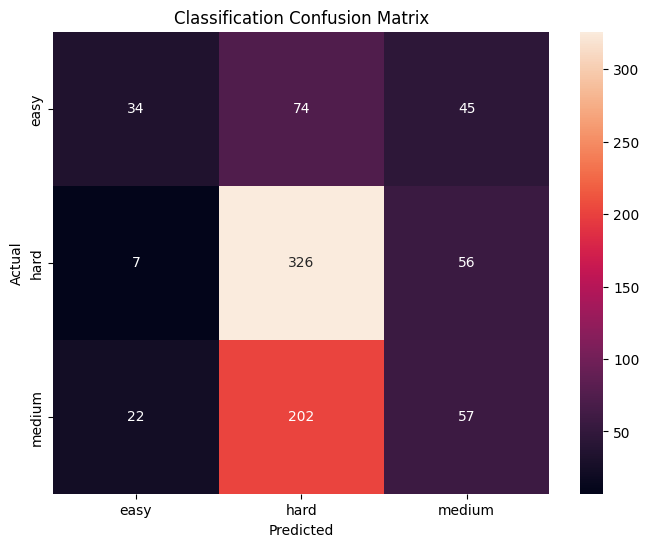

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200,max_features = 'sqrt',oob_score=True,random_state=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"OOB Score: {clf.oob_score_:.4f}")
print("\n")
print(f"Test Accuracy: {clf.score(X_test, y_test):.4f}")
print("\n")
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Confusion Matrix')
plt.show()


In [50]:

importances = clf.feature_importances_
feature_names = list(tfidf.get_feature_names_out()) + ['hard_topic_count', 'math_symbol_count', 'text_len', 'math_density']
importance_dict = dict(zip(feature_names, importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
print("TOP 10 FEATURES THE MODEL ACTUALLY USED:")
for name, val in sorted_importance[:10]:
    print(f"{name}: {val:.4f}")
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)
print("TOP 10 FEATURES THE MODEL ACTUALLY NEVER USED:")
for name, val in sorted_importance[:10]:
    print(f"{name}: {val:.4f}")

TOP 10 FEATURES THE MODEL ACTUALLY USED:
hard_topic_count: 0.0236
math_symbol_count: 0.0156
consists: 0.0070
10: 0.0065
100: 0.0064
containing: 0.0056
000: 0.0049
help: 0.0048
order: 0.0047
numbers: 0.0045
TOP 10 FEATURES THE MODEL ACTUALLY NEVER USED:
tax: 0.0000
maze: 0.0001
junctions: 0.0001
junction: 0.0001
bash: 0.0001
frog: 0.0001
l_: 0.0001
cookie: 0.0001
ice: 0.0001
n_: 0.0001
